In [2]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Input
from keras.layers.embeddings import Embedding
from keras.optimizers import SGD
from keras.layers import LeakyReLU, concatenate
from keras.callbacks import ModelCheckpoint


# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import Stemmer

# Other
import os,re
import timeit
import string
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import model_selection

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt




In [16]:
import tensorflow as tf
from keras.engine import Layer
import keras.backend as K

def reverse_gradient(X, hp_lambda):
    '''Flips the sign of the incoming gradient during training.'''
    try:
        reverse_gradient.num_calls += 1
    except AttributeError:
        reverse_gradient.num_calls = 1

    grad_name = "GradientReversal%d" % reverse_gradient.num_calls

    @tf.RegisterGradient(grad_name)
    def _flip_gradients(op, grad):
        return [tf.negative(grad) * hp_lambda]

    g = K.get_session().graph
    with g.gradient_override_map({'Identity': grad_name}):
        y = tf.identity(X)

    return y

class GradientReversal(Layer):
    '''Flip the sign of gradient during training.'''
    def __init__(self, hp_lambda, **kwargs):
        super(GradientReversal, self).__init__(**kwargs)
        self.supports_masking = False
        self.hp_lambda = hp_lambda

    def build(self, input_shape):
        self.trainable_weights = []

    def call(self, x, mask=None):
        return reverse_gradient(x, self.hp_lambda)

    def get_output_shape_for(self, input_shape):
        return input_shape

    def get_config(self):
        config = {'hp_lambda': self.hp_lambda}
        base_config = super(GradientReversal, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [3]:
encoded_data_path = "encoded_data/"

tweet_df = pd.read_pickle(encoded_data_path + "tweets.pkl")

tweet_df.info()
print("\n")
tweet_df.head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12315 entries, 0 to 12314
Data columns (total 4 columns):
id       12315 non-null int64
label    12315 non-null object
name     12315 non-null object
text     12315 non-null object
dtypes: int64(1), object(3)
memory usage: 384.9+ KB




,id,label,name,text
0,572342978255048705,racism,thefoxbandit,so drasko just said he was impressed the girls...
1,572341498827522049,racism,patricia,drasko they didn't cook half a bird you idiot ...
2,572340476503724032,racism,food,hopefully someone cooks drasko in the next ep ...
3,572334712804384768,racism,lil,of course you were born in serbia...you're as ...
4,572332655397629952,racism,jlwhitaker,these girls are the equivalent of the irritati...
5,575949086055997440,racism,dominiquew,#mkr lost the plot - where's the big texan wi...
6,551659627872415744,racism,vile_islam,@lauracdean i love how the islamofascists recr...
7,551763146877452288,racism,vile_islam,@ibnhlophe @eeviewonders @anjemchoudary a crim...
8,551768543277355009,racism,vile_islam,@anjemchoudary nothing desperate about it. hum...
9,551769061055811584,racism,vile_islam,@anjemchoudary idiots like you making such dec...


In [4]:
print(tweet_df.describe())

tweet_df['label'].value_counts()

                 id
count  1.231500e+04
mean   5.619213e+17
std    4.051089e+16
min    3.193999e+17
25%    5.641296e+17
50%    5.710391e+17
75%    5.756380e+17
max    6.847790e+17


neither    5850
sexism     4341
racism     2074
both         50
Name: label, dtype: int64

In [5]:
# shuffling 
tweet_df = tweet_df.sample(frac=1).reset_index(drop=True)
tweet_df.head(20)


,id,label,name,text
0,603528285247635456,neither,trash,@themikewebster cool i feel petty but also he ...
1,564049824274989058,sexism,male,"@bmackillopthio but, trump gets called a megal..."
2,563905276496334849,sexism,male,.@blackopal80 then what really opened my eyes....
3,563797959729352704,neither,misandrist,"leo was freaking out because of the wind, so i..."
4,567765262713298944,racism,vile_islam,@keegannyc and how about if we investigate the...
5,568231567698472961,neither,misandrist,@frozenwes i hate numpads.
6,572108345504501760,sexism,gynecologic,rt @federaltyranny: sexist femi nazi aborts ma...
7,573770498837872640,neither,misandrist,@mystyr_e we'll have more info out about this ...
8,574773417213173760,racism,vile_islam,@witnesstoallah the poor women do it because t...
9,495020834495676417,sexism,@yesyouresexist,rt @nearthetown: @viragobooks @guardian work...


In [6]:
print(tweet_df.describe())
tweet_df['label'].value_counts()


                 id
count  1.231500e+04
mean   5.619213e+17
std    4.051089e+16
min    3.193999e+17
25%    5.641296e+17
50%    5.710391e+17
75%    5.756380e+17
max    6.847790e+17


neither    5850
sexism     4341
racism     2074
both         50
Name: label, dtype: int64

In [7]:
op_file = "dataset/cleaned_tweet_data.csv"

stopWords = set(stopwords.words("english"))
stemmer = Stemmer.Stemmer('english', 100000)    

def clean_text(text):
    
    #Remove puncuation
    #text = text.translate(string.punctuation)
    
    #split based on everything except a-z0-9_'.\-
    tokens = re.findall("[a-z0-9_'.\-]+", text.lower())
    #tokens = text.lower().split()
    
    tokens = [stemmer.stemWord(w) for w in tokens if not w in stopWords and len(w) > 2 and len(w)<20]
    text = " ".join(tokens)
    
    return text


def build_data(df):
      
    data = pd.DataFrame()
    
    #cleaning text
    data['tweet'] = df['text'].map(lambda x: clean_text(x))    
    
    data['label'] = df['label']
    
    data['racism'] = df['label'].map(lambda x: 1 if x == 'racism' else 0)
    data['sexism'] = df['label'].map(lambda x: 1 if x == 'sexism' else 0)
    data['neither'] = df['label'].map(lambda x: 1 if x == 'neither' else 0)
    data['both'] = df['label'].map(lambda x: 1 if x == 'both' else 0)
    
    # set hate 1 if label is racism/sexism/both
    data['hate'] = df['label'].map(lambda x: 0 if x == 'neither' else 1)    
    
    #label =  {1:hate, 0:non-hate}
    labels_hate = data['hate'].map(lambda x : 1 if int(x) == 1 else 0)
    
    #label =  {1:hate, 0:non-hate}
    labels_racist = data['racism'].map(lambda x : 1 if int(x) == 1 else 0)
    
    data.to_csv(op_file)
    
    return (data, labels_hate, labels_racist)

data, labels_hate, labels_racist  = build_data(tweet_df)
print("Done!!!")



Done!!!


In [8]:
data.info()
print("\n")
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12315 entries, 0 to 12314
Data columns (total 7 columns):
tweet      12315 non-null object
label      12315 non-null object
racism     12315 non-null int64
sexism     12315 non-null int64
neither    12315 non-null int64
both       12315 non-null int64
hate       12315 non-null int64
dtypes: int64(5), object(2)
memory usage: 673.6+ KB




,tweet,label,racism,sexism,neither,both,hate
0,themikewebst cool feel petti also rli take sid...,neither,0,0,1,0,0
1,bmackillopthio trump get call megalomaniac. ge...,sexism,0,1,0,0,1
2,blackopal80 realli open eyes. articl financi a...,sexism,0,1,0,0,1
3,leo freak wind buri luggag could sleep. http t...,neither,0,0,1,0,0
4,keegannyc investig hate speech quran. http t.c...,racism,1,0,0,0,1
5,frozenw hate numpads.,neither,0,0,1,0,0
6,federaltyranni sexist femi nazi abort male bab...,sexism,0,1,0,0,1
7,mystyr_ we'll info soon.,neither,0,0,1,0,0
8,witnesstoallah poor women marri muslim man pre...,racism,1,0,0,0,1
9,nearthetown viragobook guardian work virtual f...,sexism,0,1,0,0,1


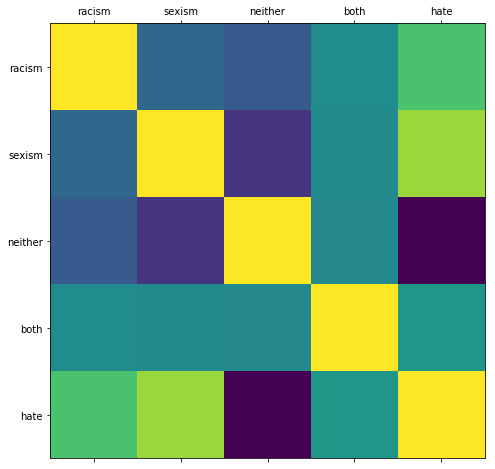

In [9]:
#Find correlation between columns

def plot_correlation(data, size=8):
    corr= data.corr()
    fig, ax =plt.subplots(figsize=(size,size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)),corr.columns)
    plt.yticks(range(len(corr.columns)),corr.columns)
    plt.show()

plot_correlation(data)

In [10]:

print(data['label'].value_counts())

print("\nhate(1) and non-hate(0) label count:-\n")
print(data['hate'].value_counts())


print("\nracism(1) and non-racism(0) label count:-\n")
print(data['racism'].value_counts())



neither    5850
sexism     4341
racism     2074
both         50
Name: label, dtype: int64

hate(1) and non-hate(0) label count:-

1    6465
0    5850
Name: hate, dtype: int64

racism(1) and non-racism(0) label count:-

0    10241
1     2074
Name: racism, dtype: int64


In [11]:
# max tweet length

tweets = data['tweet'].values

max_len = 0
max_len_tweet = ""
len_data = []
words = []

for t in tweets:
    len_data.append(len(t.split()))
    words += t.split()
    if len(t.split()) > max_len:
        max_len = len(t.split())
        max_len_tweet = t
        

VOCAB_SIZE = len(set(words))
        
print("max_len_of_tweet:", max_len,"\n")
print(max_len_tweet)

print("\nlength of top 200 tweets:-\n",sorted(len_data, reverse = True)[:400])

print("\nnumber of words: ", len(words))
print("number of unique words: ", VOCAB_SIZE)



max_len_of_tweet: 20 

ive met racist people. ive met sexist people. ive never met someon treat everi man like he rapist.. blameonenotal stupid.

length of top 200 tweets:-
 [20, 20, 20, 20, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1

In [12]:

MAX_SENT_LEN2 = 20

def process_data2(sample):  
    # Keras tokenizer function to tokenize the strings and 
    #‘texts_to_sequences’ to make sequences of words.

    #Maximum number of words to work with 
    #if set, tokenization will be restricted to the top nb_words most common words in the dataset).
    tokenizer = Tokenizer(num_words= VOCAB_SIZE)

    #fit_on_texts(texts):
    #Arguments: list of texts to train on.
    #tokenizer.fit_on_texts(data['tweet'])
    tokenizer.fit_on_texts(sample)

    #texts_to_sequences(texts)
    #texts: list of texts to turn to sequences.
    #Return: list of sequences (one per text input).
    
    #sequences = tokenizer.texts_to_sequences(data['tweet'])
    sequences = tokenizer.texts_to_sequences(sample)
    sample = pad_sequences(sequences, maxlen = MAX_SENT_LEN2)
    
    print("Processed sample shape:", sample.shape)
    #print("Sample1:", sample[0])
    
    return sample


data_embedding2 = process_data2(data['tweet'])
data_embedding2.shape

Processed sample shape: (12315, 20)


(12315, 20)

In [13]:
print(data['tweet'][0], "\n")
print(data_embedding2[0])

themikewebst cool feel petti also rli take side someon call feminazi time so....... 

[   0    0    0    0    0    0    0 7909  501   88 4160  116 3429   56
  986   65   15    7   25  439]


In [14]:
split_size = int(len(data_embedding2)*.8)

x2 = data_embedding2

# converting to numpy array
#y = labels.values
y2_hate = labels_hate
y2_racism = labels_racist

#x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size = split_size)

x2_train = x2[:split_size]
x2_test = x2[split_size:]

y2_hate_train = y2_hate[:split_size]
y2_hate_test = y2_hate[split_size:]

y2_racism_train = y2_racism[:split_size]
y2_racism_test = y2_racism[split_size:]

# transform labels into one hot representation
y2_hate_train_one_hot = (np.arange(np.max(y2_hate_train) + 1) == y2_hate_train[:, None]).astype(float)
y2_hate_test_one_hot = (np.arange(np.max(y2_hate_test) + 1) == y2_hate_test[:, None]).astype(float)

y2_racism_train_one_hot = (np.arange(np.max(y2_racism_train) + 1) == y2_racism_train[:, None]).astype(float)
y2_racism_test_one_hot = (np.arange(np.max(y2_racism_test) + 1) == y2_racism_test[:, None]).astype(float)




In [15]:
print("Hate Train split:")
print(y2_hate_train.value_counts())
print(y2_hate_train.value_counts()/len(y2_hate_train))

print("\n")
print("Hate Test split:")
print(y2_hate_test.value_counts())
print(y2_hate_test.value_counts()/len(y2_hate_test))


print("\nRacism Train split:")
print(y2_racism_train.value_counts())
print(y2_racism_train.value_counts()/len(y2_racism_train))

print("\n")
print("Racism Test split:")
print(y2_racism_test.value_counts())
print(y2_racism_test.value_counts()/len(y2_racism_test))

Hate Train split:
1    5172
0    4680
Name: hate, dtype: int64
1    0.52497
0    0.47503
Name: hate, dtype: float64


Hate Test split:
1    1293
0    1170
Name: hate, dtype: int64
1    0.52497
0    0.47503
Name: hate, dtype: float64

Racism Train split:
0    8202
1    1650
Name: racism, dtype: int64
0    0.832521
1    0.167479
Name: racism, dtype: float64


Racism Test split:
0    2039
1     424
Name: racism, dtype: int64
0    0.827852
1    0.172148
Name: racism, dtype: float64


In [27]:

VOCAB_SIZE = 21351

INP_DIM = x2_train.shape[1]
EMBED_DIM = 128
OP_DIM = 2

model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_DIM, input_length = INP_DIM))
model.add(LSTM(200, dropout = 0.2, recurrent_dropout = 0.2))



model.add(Dense(2,activation='softmax'))

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

EPOCHS = 10
BATCH_SIZE = 32


# creating checkpoint to save model every time validation accuracy improves
filepath = encoded_data_path + "weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

print('\n\nTraining Model...')

start = timeit.default_timer()

#batch_size: Integer or None. Number of samples per gradient update. 
#If unspecified, batch_size will default to 32.

model.fit(x2_train, y2_hate_train_one_hot,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              callbacks = callbacks_list,
              validation_data = (x2_test, y2_hate_test_one_hot))






Training Model...
Train on 9852 samples, validate on 2463 samples
Epoch 1/10
9852/9852 [==============================] - 57s 6ms/step - loss: 0.3679 - acc: 0.8302 - val_loss: 0.2564 - val_acc: 0.8993

Epoch 00001: val_acc improved from -inf to 0.89931, saving model to encoded_data/weights-improvement-01-0.8993.hdf5
Epoch 2/10
2080/9852 [=====>........................] - ETA: 42s - loss: 0.1343 - acc: 0.9534

KeyboardInterrupt: 

In [32]:
VOCAB_SIZE = 21351

INP_DIM = x2_train.shape[1]
EMBED_DIM = 128
OP_DIM = 2

model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_DIM, input_length = INP_DIM))
model.add(LSTM(200, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.output)

Tensor("dense_11/Softmax:0", shape=(?, 2), dtype=float32)


In [52]:
model_lstm_hate = load_model(encoded_data_path +  'weights-improvement-02-0.9054.hdf5')

y2_predicted = model_lstm_hate.predict(x2_test)
print(y2_hate_test.shape, y2_predicted.shape, type(y2_hate_test), type(y2_predicted))

y2_predicted_ = y2_predicted.argmax(axis=1)

print ('\nConfusion Matrix:')
print (confusion_matrix(y2_hate_test, y2_predicted_))


print ('\nClassification Matrix:')
print (classification_report(y2_hate_test, y2_predicted_))

(2463,) (2463, 2) <class 'pandas.core.series.Series'> <class 'numpy.ndarray'>

Confusion Matrix:
[[1024  142]
 [  91 1206]]

Classification Matrix:
             precision    recall  f1-score   support

          0       0.92      0.88      0.90      1166
          1       0.89      0.93      0.91      1297

avg / total       0.91      0.91      0.91      2463



In [53]:

VOCAB_SIZE = 21351

INP_DIM = x2_train.shape[1]
EMBED_DIM = 128
OP_DIM = 2

model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_DIM, input_length = INP_DIM))
model.add(LSTM(200, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(2,activation='softmax'))

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

EPOCHS = 10
BATCH_SIZE = 8


# creating checkpoint to save model every time validation accuracy improves
filepath = encoded_data_path + "weights-racism-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

print('\n\nTraining Model...')

start = timeit.default_timer()

#batch_size: Integer or None. Number of samples per gradient update. 
#If unspecified, batch_size will default to 32.

model.fit(x2_train, y2_racism_train_one_hot,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              callbacks = callbacks_list,
              validation_data = (x2_test, y2_racism_test_one_hot))






Training Model...
Train on 9852 samples, validate on 2463 samples
Epoch 1/10
9852/9852 [==============================] - 162s 16ms/step - loss: 0.1311 - acc: 0.9578 - val_loss: 0.0770 - val_acc: 0.9773

Epoch 00001: val_acc improved from -inf to 0.97726, saving model to encoded_data/weights-racism-improvement-01-0.9773.hdf5
Epoch 2/10
9852/9852 [==============================] - 152s 15ms/step - loss: 0.0206 - acc: 0.9938 - val_loss: 0.0904 - val_acc: 0.9781

Epoch 00002: val_acc improved from 0.97726 to 0.97808, saving model to encoded_data/weights-racism-improvement-02-0.9781.hdf5
Epoch 3/10
9852/9852 [==============================] - 149s 15ms/step - loss: 0.0112 - acc: 0.9975 - val_loss: 0.0988 - val_acc: 0.9765

Epoch 00003: val_acc did not improve from 0.97808
Epoch 4/10
9852/9852 [==============================] - 152s 15ms/step - loss: 0.0050 - acc: 0.9989 - val_loss: 0.1174 - val_acc: 0.9712

Epoch 00004: val_acc did not improve from 0.97808
Epoch 5/10
9852/9852 [=========

KeyboardInterrupt: 

In [54]:
model_lstm_racism = load_model(encoded_data_path +  'weights-racism-improvement-05-0.9793.hdf5')

y2_predicted = model_lstm_racism.predict(x2_test)
print(y2_racism_test.shape, y2_predicted.shape, type(y2_racism_test), type(y2_predicted))

y2_predicted_ = y2_predicted.argmax(axis=1)

print ('\nConfusion Matrix:')
print (confusion_matrix(y2_racism_test, y2_predicted_))


print ('\nClassification Matrix:')
print (classification_report(y2_racism_test, y2_predicted_))

(2463,) (2463, 2) <class 'pandas.core.series.Series'> <class 'numpy.ndarray'>

Confusion Matrix:
[[2037   16]
 [  35  375]]

Classification Matrix:
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      2053
          1       0.96      0.91      0.94       410

avg / total       0.98      0.98      0.98      2463



In [26]:
model_lstm_racism

NameError: name 'model_lstm_racism' is not defined

In [36]:
INP_DIM = x2_train.shape[1]

input_hate = Input(shape=(INP_DIM,), name='input_hate')
input_race = Input(shape=(INP_DIM,), name='input_race')

x_hate = Embedding(output_dim=128, input_dim=VOCAB_SIZE, input_length = INP_DIM)(input_hate)
x_race = Embedding(output_dim=128, input_dim=VOCAB_SIZE, input_length = INP_DIM)(input_race)

lstm_hate_out = LSTM(100)(x_hate)
lstm_race_out = LSTM(100)(x_race)

x = concatenate([lstm_hate_out, lstm_race_out])

x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
#x = Dense(64, activation='relu')(x)

hate_output = Dense(2, activation='softmax', name='hate_output')(x)
race_output = Dense(2, activation='softmax', name='race_output')(x)

#This defines a model with two inputs and two outputs:
model = Model(inputs=[input_hate, input_race], outputs=[hate_output, race_output])


#We compile the model and assign a weight of 0.2 to the auxiliary loss. 
#To specify different loss_weights or lossfor each different output, you can use a list or a dictionary. 
#Here we pass a single loss as the loss argument, so the same loss will be used on all outputs.
"""
model.compile(optimizer='rmsprop', loss='binary_crossentropy',
              loss_weights=[1., 0.2])

#We can train the model by passing it lists of input arrays and target arrays:
model.fit([headline_data, additional_data], [labels, labels],
          epochs=50, batch_size=32)
"""

#Since our inputs and outputs are named (we passed them a "name" argument), 
#we could also have compiled the model via
model.compile(optimizer='adam',
              loss={'hate_output': 'binary_crossentropy', 'race_output': 'binary_crossentropy'},
              loss_weights={'hate_output': 1., 'race_output': -1.0})

# And trained it via:
model.fit({'input_hate': x2_train, 'input_race': x2_train},
          {'hate_output': y2_hate_train_one_hot, 'race_output': y2_racism_train_one_hot},
          epochs=10, batch_size=16)



Epoch 1/10
9852/9852 [==============================] - 142s 14ms/step - loss: -12.4621 - hate_output_loss: 0.5704 - race_output_loss: 13.0324
Epoch 2/10
9852/9852 [==============================] - 126s 13ms/step - loss: -13.1731 - hate_output_loss: 0.1709 - race_output_loss: 13.3440
Epoch 3/10
9852/9852 [==============================] - 139s 14ms/step - loss: -13.2903 - hate_output_loss: 0.0545 - race_output_loss: 13.3447
Epoch 4/10
9852/9852 [==============================] - 124s 13ms/step - loss: -13.3184 - hate_output_loss: 0.0271 - race_output_loss: 13.3455
Epoch 5/10
9852/9852 [==============================] - 127s 13ms/step - loss: -13.3251 - hate_output_loss: 0.0204 - race_output_loss: 13.3455
Epoch 6/10
9852/9852 [==============================] - 137s 14ms/step - loss: -13.3302 - hate_output_loss: 0.0153 - race_output_loss: 13.3455
Epoch 7/10
9852/9852 [==============================] - 132s 13ms/step - loss: -13.3323 - hate_output_loss: 0.0133 - race_output_loss: 13.3455

In [71]:
"""
Confusion Matrix:
[[1024  142]
 [  91 1206]]

Classification Matrix:
             precision    recall  f1-score   support

          0       0.92      0.88      0.90      1166
          1       0.89      0.93      0.91      1297

avg / total       0.91      0.91      0.91      2463

"""

prediction = model.predict([x2_test, x2_test])
x2_test.shape, prediction[0].shape, prediction[1].shape

prediction = np.argmax(prediction[0], axis=1)

print ('\nConfusion Matrix:')
print (confusion_matrix(y2_hate_test, prediction))


print ('\nClassification Matrix:')
print (classification_report(y2_hate_test, prediction))


Confusion Matrix:
[[1083   83]
 [ 179 1118]]

Classification Matrix:
             precision    recall  f1-score   support

          0       0.86      0.93      0.89      1166
          1       0.93      0.86      0.90      1297

avg / total       0.90      0.89      0.89      2463



In [72]:
prediction = model.predict([x2_test, x2_test])
x2_test.shape, prediction[1].shape, prediction[1].shape

prediction = np.argmax(prediction[1], axis=1)

print ('\nConfusion Matrix:')
print (confusion_matrix(y2_racism_test, prediction))


print ('\nClassification Matrix:')
print (classification_report(y2_racism_test, prediction))


Confusion Matrix:
[[   0 2053]
 [   0  410]]

Classification Matrix:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      2053
          1       0.17      1.00      0.29       410

avg / total       0.03      0.17      0.05      2463



C:\Anaconda5.2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:



INP_DIM = x2_train.shape[1]

input_hate = Input(shape=(INP_DIM,), name='input_hate')
input_race = Input(shape=(INP_DIM,), name='input_race')

x_hate = Embedding(output_dim=128, input_dim=VOCAB_SIZE, input_length = INP_DIM)(input_hate)
x_race = Embedding(output_dim=128, input_dim=VOCAB_SIZE, input_length = INP_DIM)(input_race)

lstm_hate_out = LSTM(100)(x_hate)
lstm_race_out = LSTM(100)(x_race)

lstm_race_out = GradientReversal(.8)(lstm_race_out)

x = concatenate([lstm_hate_out, lstm_race_out])

x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x.add(Dense(2, activation='softmax', name='hate_output'))
#x = Dense(64, activation='relu')(x)
#hate_output = Dense(2, activation='softmax', name='hate_output')(x)

#hate_output = Dense(2, activation='softmax', name='hate_output')(x)
#race_output = Dense(2, activation='softmax', name='race_output')(x)

#This defines a model with two inputs and two outputs:
model = Model(inputs=input_hate, outputs=hate_output)


#We compile the model and assign a weight of 0.2 to the auxiliary loss. 
#To specify different loss_weights or lossfor each different output, you can use a list or a dictionary. 
#Here we pass a single loss as the loss argument, so the same loss will be used on all outputs.
"""
model.compile(optimizer='rmsprop', loss='binary_crossentropy',
              loss_weights=[1., 0.2])

#We can train the model by passing it lists of input arrays and target arrays:
model.fit([headline_data, additional_data], [labels, labels],
          epochs=50, batch_size=32)
"""

#Since our inputs and outputs are named (we passed them a "name" argument), 
#we could also have compiled the model via
model.compile(optimizer='adam',
              loss={'hate_output': 'binary_crossentropy'},
              loss_weights={'hate_output': 1})

# And trained it via:
model.fit({'input_hate': x2_train},
          {'hate_output': y2_hate_train_one_hot},
          epochs=10, batch_size=16)



ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_race_2:0", shape=(?, 20), dtype=float32) at layer "input_race". The following previous layers were accessed without issue: []

In [41]:

VOCAB_SIZE = 21351

hp_lambda = .5
INP_DIM = x2_train.shape[1]
EMBED_DIM = 128
OP_DIM = 2

input_hate = Input(shape=(INP_DIM,), name='input_hate')
x_hate = Embedding(output_dim=128, input_dim=VOCAB_SIZE, input_length = INP_DIM)(input_hate)
lstm_hate_out = LSTM(100)(x_hate)

Flip = GradientReversal(hp_lambda)

dann_in = Flip(lstm_hate_out)
dann_out = Dense(2, activation='softmax')(dann_in)


#Flip = flipGradientTF.GradientReversal(hp_lambda)
#dann_in = Flip(previous_layer_output)
#dann_out = Dense(2)(dann_in)

dann_out = Model(input_hate) 
dann_out.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])


EPOCHS = 10
BATCH_SIZE = 8


# creating checkpoint to save model every time validation accuracy improves
filepath = encoded_data_path + "weights-racism-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

print('\n\nTraining Model...')

start = timeit.default_timer()

#batch_size: Integer or None. Number of samples per gradient update. 
#If unspecified, batch_size will default to 32.

model.fit(x2_train, y2_racism_train_one_hot,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              callbacks = callbacks_list,
              validation_data = (x2_test, y2_racism_test_one_hot))






Training Model...


ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[    0,     0,     0, ...,     7,    25,   439],
       [    0,     0,     0, ...,     8,    15,  7911],
       [    0,     0,     0, ...,  7913,   281,   548],
       ...,
       [    0,     ...

In [ ]:
# This returns a tensor
inputs = Input(shape=(x2_train.shape[1],))

x = Embedding(output_dim=25, input_dim=VOCAB_SIZE, input_length = INP_DIM)(inputs)

# a layer instance is callable on a tensor, and returns a tensor
x = LSTM(32)(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

#predictions = Dense(2, activation='softmax')(x)

Flip = GradientReversal(1)

dann_in = Flip(x)
dann_out = Dense(2, activation='softmax')(x)


print("sfsfsf")


# This creates a model that includes
# the Input layer and three Dense layers
# predictions is made of an input layer and 3 dense layers
model = Model(inputs=inputs, outputs=dann_out)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x2_train, y2_hate_train_one_hot,
              batch_size = 8,
              epochs = 100,
              callbacks = callbacks_list,
              validation_data = (x2_test, y2_hate_test_one_hot))





sfsfsf
Train on 9852 samples, validate on 2463 samples
Epoch 1/100
9852/9852 [==============================] - 43s 4ms/step - loss: 0.3842 - acc: 0.8279 - val_loss: 0.2908 - val_acc: 0.8802 0.3874  - ETA: 1s -

Epoch 00001: val_acc improved from 0.52497 to 0.88023, saving model to encoded_data/weights-racism-improvement-01-0.8802.hdf5
Epoch 2/100
9852/9852 [==============================] - 43s 4ms/step - loss: 0.2587 - acc: 0.8997 - val_loss: 0.2779 - val_acc: 0.8863

Epoch 00002: val_acc improved from 0.88023 to 0.88632, saving model to encoded_data/weights-racism-improvement-02-0.8863.hdf5
Epoch 3/100
9852/9852 [==============================] - 41s 4ms/step - loss: 0.2267 - acc: 0.9139 - val_loss: 0.2783 - val_acc: 0.8940

Epoch 00003: val_acc improved from 0.88632 to 0.89403, saving model to encoded_data/weights-racism-improvement-03-0.8940.hdf5
Epoch 4/100
9852/9852 [==============================] - 41s 4ms/step - loss: 0.2036 - acc: 0.9235 - val_loss: 0.2660 - val_acc: 0.8936


9852/9852 [==============================] - 36s 4ms/step - loss: 0.0266 - acc: 0.9958 - val_loss: 1.5861 - val_acc: 0.8303

Epoch 00041: val_acc did not improve from 0.90418
Epoch 42/100
9852/9852 [==============================] - 36s 4ms/step - loss: 0.0195 - acc: 0.9956 - val_loss: 1.7154 - val_acc: 0.8307

Epoch 00042: val_acc did not improve from 0.90418
Epoch 43/100
9852/9852 [==============================] - 38s 4ms/step - loss: 0.0210 - acc: 0.9961 - val_loss: 1.4880 - val_acc: 0.8238

Epoch 00043: val_acc did not improve from 0.90418
Epoch 44/100
9852/9852 [==============================] - 36s 4ms/step - loss: 0.0288 - acc: 0.9958 - val_loss: 1.9813 - val_acc: 0.8254

Epoch 00044: val_acc did not improve from 0.90418
Epoch 45/100
9852/9852 [==============================] - 36s 4ms/step - loss: 0.0212 - acc: 0.9955 - val_loss: 1.7804 - val_acc: 0.8380

Epoch 00045: val_acc did not improve from 0.90418
Epoch 46/100
9852/9852 [==============================] - 36s 4ms/step - 

In [33]:
# This returns a tensor
inputs = Input(shape=(x2_train.shape[1],))

x = Embedding(output_dim=25, input_dim=VOCAB_SIZE, input_length = INP_DIM)(inputs)

# a layer instance is callable on a tensor, and returns a tensor
x = LSTM(32)(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

#predictions = Dense(2, activation='softmax')(x)

Flip = GradientReversal(1)

dann_in = Flip(x)
dann_out = Dense(2, activation='softmax')(x)


print("sfsfsf")


# This creates a model that includes
# the Input layer and three Dense layers
# predictions is made of an input layer and 3 dense layers
model = Model(inputs=inputs, outputs=dann_out)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x2_train, y2_hate_train_one_hot,
              batch_size = 8,
              epochs = 100,
              callbacks = callbacks_list,
              validation_data = (x2_test, y2_hate_test_one_hot))



